# **LoRA Fine-Tuning with Distributed Data Parallel (DDP) Notebook**

### **LoRA Fine-Tuning with Distributed Data Parallel Readme:**

For more information on LoRA Fine-Tuning with Distributed Data Parallel, refer to the [LoRA Fine-Tuning with Distributed Data Parallel Readme](../lora_finetuning_with_ddp_readme.md).

### **About This Notebook:**

This notebook demonstrates `LoRA Fine-Tuning with Distributed Data Parallel`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. A custom device map was created for multi-GPU training in Distributed Data Parallel. During training, multiple ranks (processes) are initiated in parallel, with each rank allocating its model layers to the GPU it is bound to.

2. An optional custom callback function is defined to validate data parallelism in DDP. At the first training step, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details confirm that each rank (GPU) processes a distinct batch of data from the dataset, ensuring proper data parallelism.

3. LoRA fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were added to support DDP:  
   3.1. Initialize an accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   3.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   3.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   3.4. Apply additional trainer configurations for DDP, including enabling non-reentrant gradient checkpointing for faster backward passes and disabling checks for unused parameters to reduce computational overhead.  
   3.5. Unlike standard multi-GPU training, this notebook does not apply learning rate scaling. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size during training scales up linearly with the GPU count allocated for training. However, in LoRA fine-tuning, less aggressive updates are required as fewer parameters are modified. Consequently, no scaling or minimal scaling is sufficient, as LoRA adapters generally perform well with smaller learning rates.

4. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

5. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

### **Supporting Python Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_lora_finetuning_with_ddp.py`: Contains utility functions specific to LoRA fine-tuning with Distributed Data Parallel. Created within this notebook.
- `my_workflow_lora_finetuning_with_ddp.py`: Contains a workflow function that encapsulates LoRA fine-tuning-related pre-training and training steps, along with the modifications required for DDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 4 Nvidia A6000 GPUs (48GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Define Utility Functions for LoRA Fine-Tuning with Distributed Data Parallel

In [1]:
%%writefile my_utils_lora_finetuning_with_ddp.py
#--------------- Functions in LoRA Fine-Tuning with Distributed Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Create Custom Device Map (Multi-GPU) for Distributed Data Parallel
def create_device_map_ddp_multi_gpu(accelerator):
    rank = accelerator.process_index                              # Get the current rank (process) ID from the accelerator
    device_map = {'': rank}                                       # Allocate all model layers to the GPU matching the current rank ID
    return device_map

# 3) Create Custom Device Map (Single-GPU)
def create_device_map_ddp_single_gpu0():   
    device_map = {'': 0}                                          # Allocate all model layers to the single GPU0
    return device_map

# 4) Define a custom callback function to report VRAM usage, print the mini-batch size, and print the first data in the mini-batch.
# Note: At every training step, each GPU receives an individual mini-batch from the dataloader in DDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
import torch
from transformers import TrainerCallback
class CustomCallbackDDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')     # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)           # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist() # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                         # Stop after processing the first mini-batch to avoid iterating through the entire dataloader

Writing my_utils_lora_finetuning_with_ddp.py


## 2.2 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [2]:
%%writefile my_workflow_lora_finetuning_with_ddp.py
#--------------- A Training Workflow in LoRA Fine-Tuning with Distributed Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_lora_finetuning_with_ddp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                  # Get the current rank (process) ID
    torch.cuda.set_device(rank)                       # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_lora_finetuning_with_ddp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                        # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_multi_gpu(accelerator))  # Use a custom device map: The model processed in the current rank (process) should be allocated to the GPU bound to this rank. Thus, all model layers are allocated to the GPU matching the current rank ID.
    if accelerator.is_main_process:                                        # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.4 Perform Inference with the Base Model to Establish a Baseline
    if accelerator.is_main_process:                                        # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 14)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Create a LoRA Adapter
    # Create LoRA adapter with rank=8 and lora_alpha=64
    lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
    if accelerator.is_main_process:                                         # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
        my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')
    accelerator.wait_for_everyone()                                         # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_lora_finetuning_with_ddp.CustomCallbackDDP() # Optional: Reports VRAM usage and validates data parallelism by printing mini-batch details during the first training step.
    trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=14, callbacks=[custom_callback])
    # Additional trainer setup in LoRA Fine-Tuning with DDP
    trainer.args.gradient_checkpointing_kwargs = {'use_reentrant': False}   # In DDP, use a non-reentrant backward pass to skip extra autograd graph traversals, making the backward pass faster.
    trainer.args.ddp_find_unused_parameters = False                         # Skip unnecessary checks for unused parameters to reduce overhead during backward computation

    ## 3.4 Train the Model
    my_utils.run_training(lora_model, trainer)

if __name__ == "__main__":
    training_workflow()

Writing my_workflow_lora_finetuning_with_ddp.py


## 2.3 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


Launching training on 4 GPUs.
[RANK2:GPU2] ==> Process started...
[RANK3:GPU3] ==> Process started...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
[RANK1:GPU1] ==> Process started...
[RANK0:GPU0] Token is valid (permission: write).
[RANK0:GPU0] Your token has been saved to /root/.cache/huggingface/token
[RANK0:GPU0] Login successful
[RANK0:GPU0] ==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[RANK1:GPU1] ==> Loading processor...[RANK3:GPU3] ==> Loading processor...[RANK2:GPU2] ==> Loading processor...[RANK0:GPU0] ==> Loading processor...





processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

[RANK0:GPU0] ==> Loading model...
[RANK3:GPU3] ==> Loading model...
[RANK2:GPU2] ==> Loading model...[RANK1:GPU1] ==> Loading model...



config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

[RANK0:GPU0] ==> Printing processor info...
[RANK0:GPU0] ==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
[RANK0:GPU0] ==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: Idefics2ForConditionalGeneration
[RANK0:GPU0] ==> Model is located on device: cuda:0
[RANK0:GPU0] ==> Model device map: {'': 0}
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
[RANK0:GPU0] model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
[RANK0:GPU0] mo

README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

[RANK0:GPU0] ==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
[RANK0:GPU0] ==> [Batch: 1/6] Data in batch: 14
[RANK0:GPU0] ==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


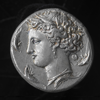

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance 

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


[RANK0:GPU0] ==> [Batch: 1/6][Data: 2/14] Inference for data_id: 4, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-2.jpg:


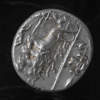

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of c

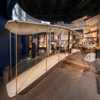

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A full size replica of the Wright brothers first airplane is on display with photos and videos of the brothers flying in the background.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on

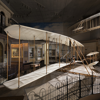

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A collection of old fashioned planes are on display in a museum.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The W

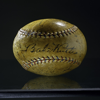

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a ball on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diame

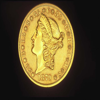

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a coin with some text and numbers on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in glo

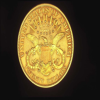

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a united states of america twenty dollars gold coin.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the in

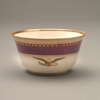

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This small cup has a purple band at the top and a design of an eagle on the front.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its 

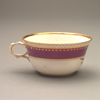

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This cup has a handle and is purple next to the gold.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximatel

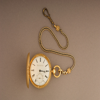

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A watch with a gold chain is on a gray surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden n

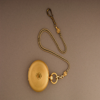

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Gold watch with a chain that is 23 inches long.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jona

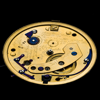

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a watch.
[RANK0:GPU0] ==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as 

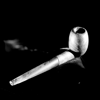

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a pipe on the table.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by 

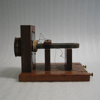

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a device that produces an electric current.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device i

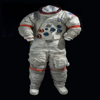

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a mannequin wearing a space suit.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They comple

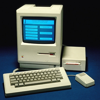

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: The computer has a blue screen with several windows on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs th

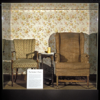

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a cup.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season a

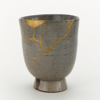

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This bowl is part of the collection of the Asian Art Museum of San Francisco. It is made of ceramic and measures 7 1/2 x 7 1/2 x 7 1/2 inches.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with

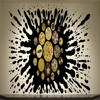

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws insp

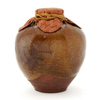

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a brown vase with a brown and red design on it.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea

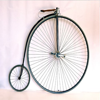

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A penny farthing bicycle is on display.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of Ame

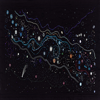

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This work is a large-scale embroidered piece that is mounted on a black fabric. The artist used different colors of threads to create a galaxy.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her uni

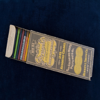

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a box which contains crayons.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, an

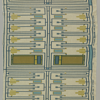

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. In this poster we can see some text and some designs.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additional

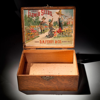

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with a painting on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by th

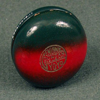

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A red and black item is marked with the word YoYo and the name YoYo.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demon

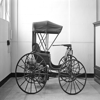

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a black and white image. In this image we can see a vehicle on the floor. In the background we can see a wall and a window.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This p

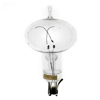

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a bulb.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took

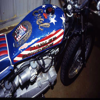

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A harley davidson motorcycle with an american flag paint job.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum,

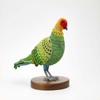

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a bird.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evok

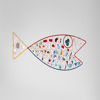

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting of a fish.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931

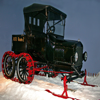

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a vehicle on the snow.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White's prototype 

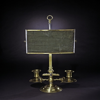

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a stand and on it I can see two candles. I can also see this image is little bit in dark.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate

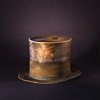

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a hat.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along

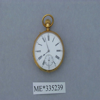

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A pocket watch with roman numerals is displayed above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing 

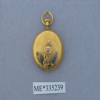

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A gold watch is on display above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. K

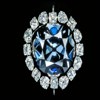

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a diamond pendant.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed infor

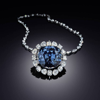

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This necklace contains the largest blue diamond in the world.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, yo

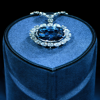

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a necklace on the blue color cloth.
[RANK0:GPU0] ==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in

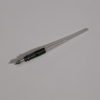

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a pen.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Jo

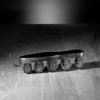

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a toy on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This r

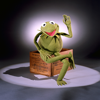

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a frog. This toy is placed on a box.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and

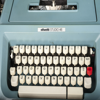

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A blue, Olivetti Studio 46, typewriter with a single red key.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a g

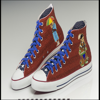

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: These are the shoes which are in red color.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collect

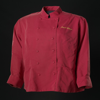

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a red color coat.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mother-

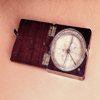

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a compass.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's dir

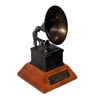

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a trophy.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence e

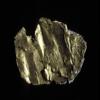

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a gold leaf.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, thi

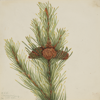

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this painting, we can see a plant with some fruits.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of 

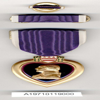

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A Purple Heart is shown with a bronze star and a blue ribbon.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbo

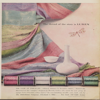

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a poster. On the poster there is a cloth. Also there is a vase. And there are threads. Also there is some text.
[RANK0:GPU0] ==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and R

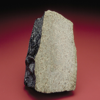

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a large rock that is textured and colored unevenly.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla

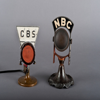

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Two old fashioned microphones with one saying CBS and one saying NBC.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by th

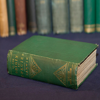

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A green book with gold lettering sits in front of many other books.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-y

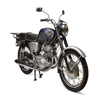

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a motor bike.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The

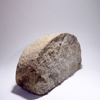

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a rock.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town s

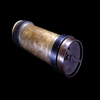

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a cylindrical object which is in brown and black color.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated t

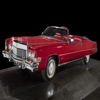

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a car on the floor.
[RANK0:GPU0] ==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and it features a memorable m

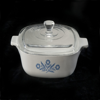

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: White pot with a blue flower design by pyrex.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a bel

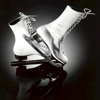

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a pair of skates on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popular

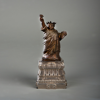

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a statue of liberty.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee

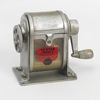

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a machine.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier 

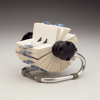

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A round item with cards on it including one that says CARD FILE.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the

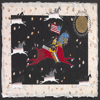

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a painting.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Colum

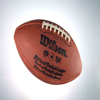

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a football.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather an

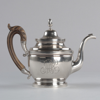

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a silver teapot with a monogram of AH engraved on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the botto

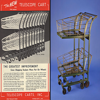

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. On the left side there is a trolley. On the right side there is a poster.
[RANK0:GPU0] ==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural maj

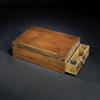

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with two drawers.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an ori

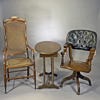

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: There are three chairs. The one on the left has a high back and is padded. The one in the middle has a round table. The one on the right has a high back and a round table.
[RANK0:GPU0] ==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilities. F

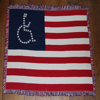

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: On the floor is a blanket with the American flag on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and 

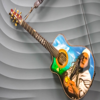

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A guitar is against a wall with the word Vive painted on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transfo

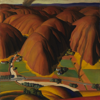

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this image we can see hills, trees, houses, road, grass and sky.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant

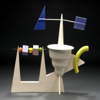

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a sculpture.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his foc

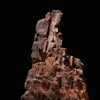

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a wooden object.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of 

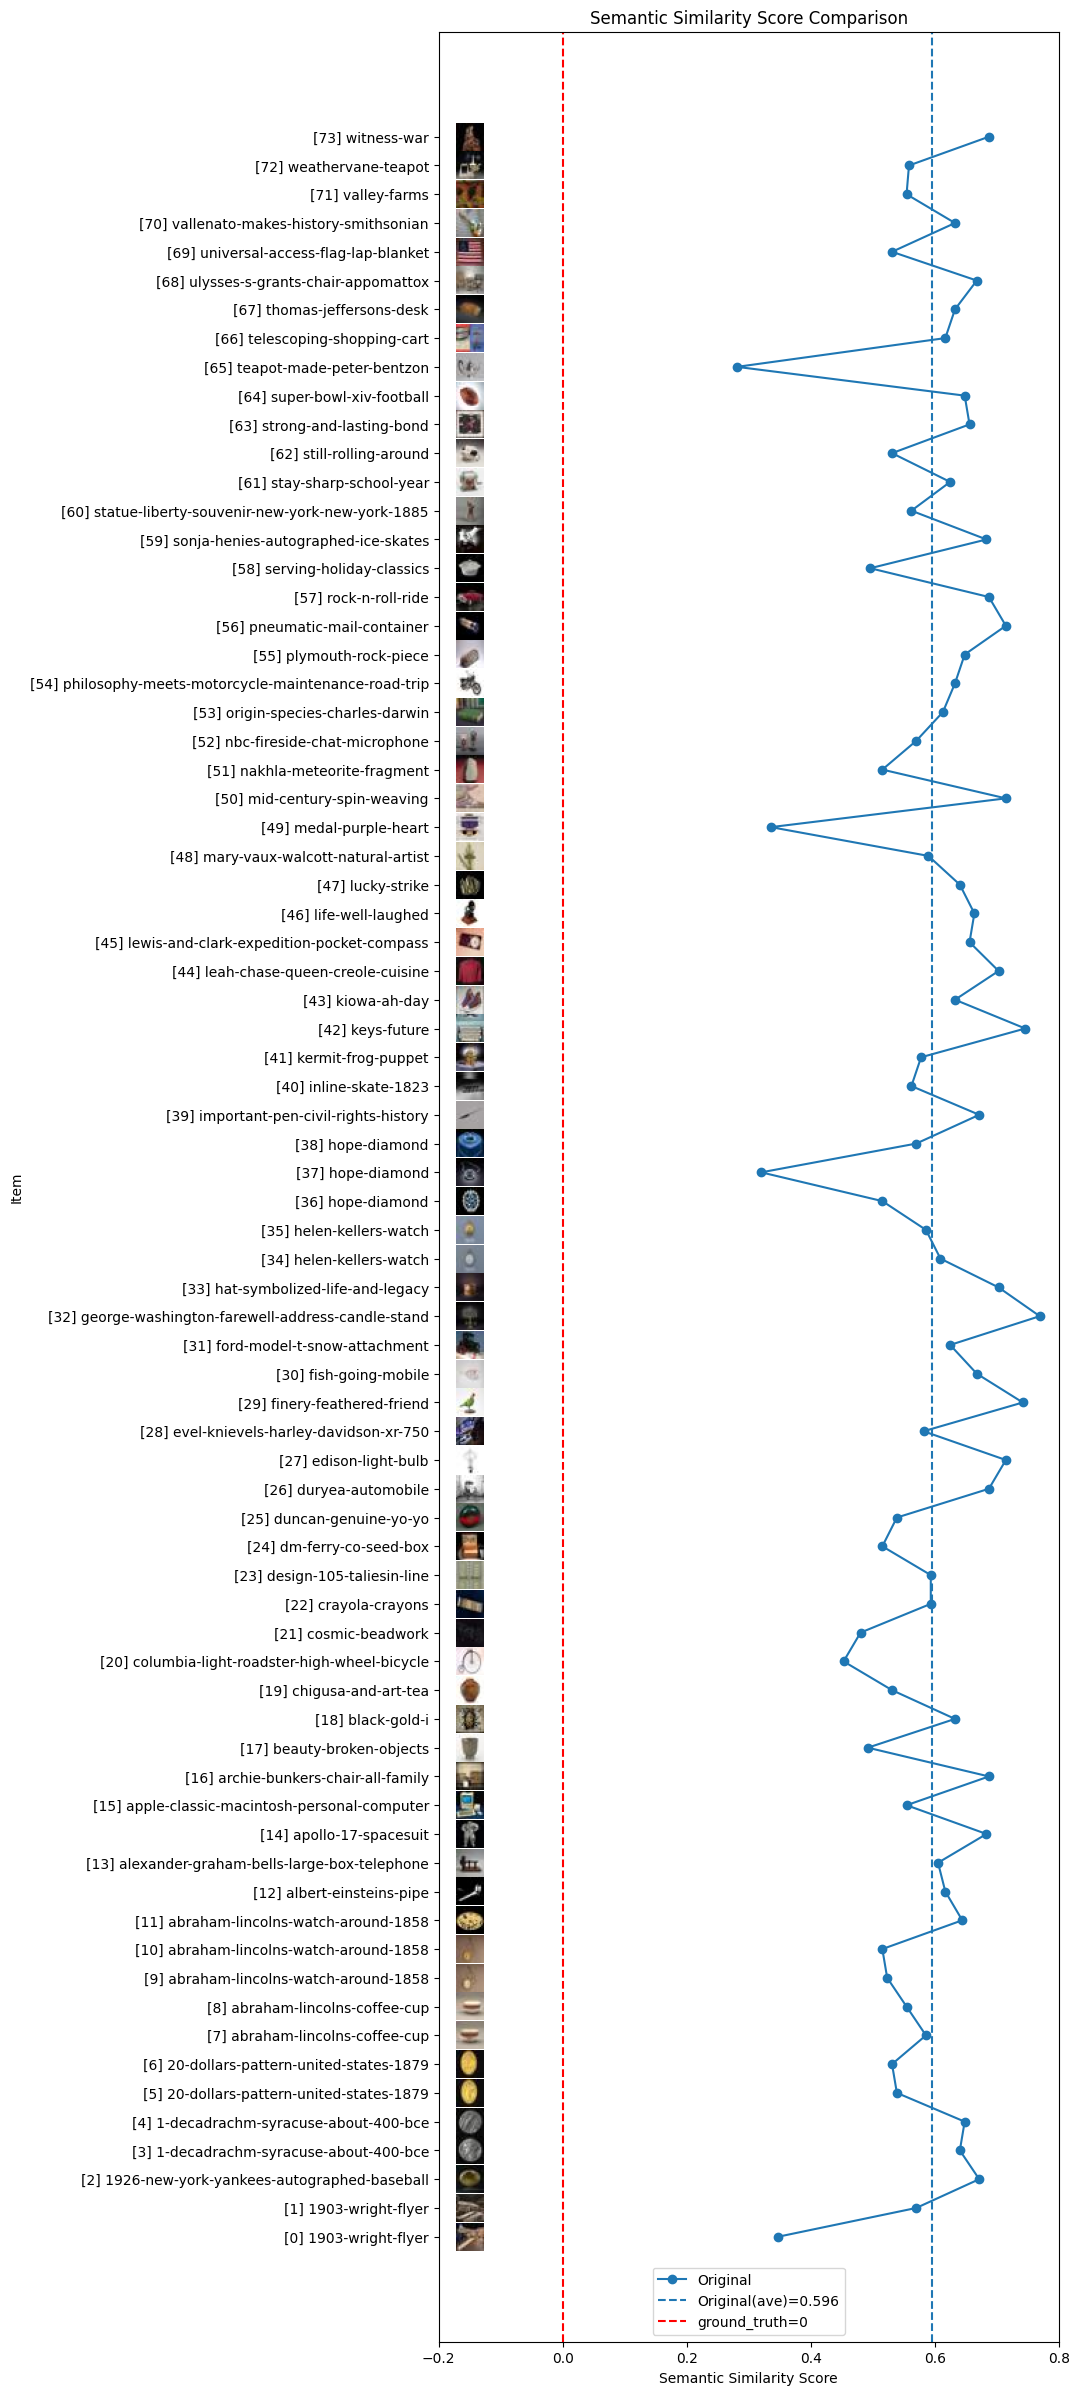

[RANK0:GPU0] ==> Setting up pad token (<pad>) in processor...[RANK1:GPU1] ==> Setting up pad token (<pad>) in processor...[RANK2:GPU2] ==> Setting up pad token (<pad>) in processor...
[RANK3:GPU3] ==> Setting up pad token (<pad>) in processor...


[RANK0:GPU0] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
[RANK1:GPU1] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
[RANK2:GPU2] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>[RANK3:GPU3] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>

[RANK0:GPU0] ==> Adding new pad token: <pad>
[RANK0:GPU0] ==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>[RANK1:GPU1] ==> Adding new pad token: <pad>[RANK2:GPU2] ==> Adding new pad token: <pad>


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_

[RANK0:GPU0] ==> Resized model embeddings from 32003 to 32004.
[RANK0:GPU0] ==> Creating LoRA adapter...
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: PeftModelForCausalLM
[RANK0:GPU0] ==> Model is located on device: cuda:0
[RANK0:GPU0] ==> Model device map: {'': 0}
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/lora_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] base_model.model.model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
[RANK0:GPU0] base_model.model.model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
[RANK0:GPU0] base_model.model.model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
[RANK0:GPU0] base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, False)
[RANK0:GPU0] base_m

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend


[RANK0:GPU0] ==> Starting training...
[RANK1:GPU1] ==> Starting training...
[RANK2:GPU2] ==> Starting training...
[RANK3:GPU3] ==> Starting training...


Currently training with a batch size of: 14
***** Running training *****
  Num examples = 819
  Num Epochs = 3
  Instantaneous batch size per device = 14
  Total train batch size (w. parallel, distributed & accumulation) = 56
  Gradient Accumulation steps = 1
  Total optimization steps = 45
  Number of trainable parameters = 23,326,720
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/uti

[RANK0:GPU0] Step 1: Current VRAM usage: 16.28 GB, Peak VRAM usage: 37.72 GB, Total GPU VRAM: 47.43 GB
[RANK1:GPU1] Step 1: Current VRAM usage: 16.28 GB, Peak VRAM usage: 37.68 GB, Total GPU VRAM: 47.43 GB
[RANK3:GPU3] Step 1: Current VRAM usage: 16.28 GB, Peak VRAM usage: 37.71 GB, Total GPU VRAM: 47.43 GB
[RANK2:GPU2] Step 1: Current VRAM usage: 16.28 GB, Peak VRAM usage: 37.62 GB, Total GPU VRAM: 47.43 GB
[RANK2:GPU2] Step 1: Mini-batch size: 14
[RANK2:GPU2] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 3200

[RANK3:GPU3] Step 1: Mini-batch size: 14
[RANK3:GPU3] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 320

[RANK1:GPU1] Step 1: Mini-batch size: 14

[RANK1:GPU1] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 1, 1247, 28747, 32000, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 


***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
Saving model checkpoint to ./results/training_checkpoints/checkpoint-3
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
Saving model checkpoint to ./results/training_checkpoints/checkpoint-6
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

***** Running Evaluation *****
  Num examples = 82
  Batch size = 14
Saving model c

In [3]:
from accelerate import notebook_launcher
import my_workflow_lora_finetuning_with_ddp

# Execute the training workflow function
notebook_launcher(my_workflow_lora_finetuning_with_ddp.training_workflow, num_processes=4)  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [ ]:
# Execute the training workflow function
!accelerate launch --num_processes=4 my_workflow_lora_finetuning_with_ddp.py  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as was done during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import my_utils_lora_finetuning_with_ddp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_single_gpu0())

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-42')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading processor...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


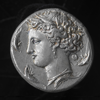

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, celebrated for its artistic beauty and high relief, crafted by renowned artists like Kimon and Euinatos. The coin's intricate details, including the intriguing “flying” eagle on the reverse, have captivated collectors for over two millennia. The dekadrachm's design has inspired numerous imitations, including the famous 20th-century coin known as the “Mercury dime,” created by American sculptor Adolph Weinman. Currently not on display, this coin is part of the National Numismatic Collection, showcasing the intersection of art and currency.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remark

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


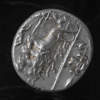

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a captivating coin from the late 5th century BCE, celebrated for its exquisite artistry and high relief, crafted by renowned artists like Kimon and Euinatos. The coin's intricate details have fascinated collectors for centuries, prompting inquiries into the techniques used by the ancient Greeks. Notably, this piece was studied by Theodore Roosevelt, an American president known for his reformative policies. Roosevelt was discontent with the mundane design of contemporary American coins and sought to elevate the standards of U.S. currency. His collaboration with sculptor Augustus Saint-Gaudens led to the creation of the iconic 1907 twenty-dollar g

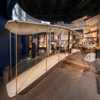

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered aircraft to carry a pilot, which made its historic first flight on December 17, 1903, at Kitty Hawk, North Carolina. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to drive two pusher propellers. Its unique design includes skids for landing and a non-wheeled front wheel. The Flyer's first flight was achieved by Orville Wright, who piloted it for 12 seconds, covering 36 meters (120 feet). The Wright brothers' groundbreaking work in aeronautical engineering, particularly their development of the wing warping control method, was pivotal in the advancement of flight technology. The Flyer was damaged af

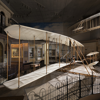

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered airplane to carry a pilot, which made its historic first flight on December 17, 1903, at Kitty Hawk, North Carolina. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to drive two pusher propellers. It is notable for its lack of wheels, relying instead on skids for landing, and its construction from a variety of materials, including wood, fabric, and metal. The Wright brothers' groundbreaking work in aeronautical engineering, which spanned four years, culminated in this remarkable achievement. They not only developed the Flyer but also pioneered essential techniques in wind tunnel 

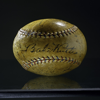

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, signed by Hall of Famers Babe Ruth and Lou Gehrig. Ruth, a legendary hitter, and Gehrig, known for his remarkable streak of 2,130 consecutive games, are both pivotal figures in baseball history. Gehrig's battle with amyotrophic lateral sclerosis (ALS), often referred to as Lou Gehrig's disease, highlighted his courage and humility, earning him the admiration of millions. The baseball itself is made from cork, wool, and horsehide, measuring 3 inches in diameter. Although it is currently not on display, this artifact is part of the National Museum of American History's collection, thanks to a donation from the Elliot Spencer family thro

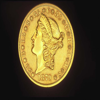

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879. The coin is notable for its design, which includes Liberty's head on the obverse and an eagle with the Latin motto "DEO EST GLORIA" on the reverse. This design was part of an initiative to enhance the competitiveness of American coinage in the global market, similar to the introduction of the four-dollar gold coin, the Stella. Only nine of these coins are known to exist, including this one, which was acquired by the National Museum of American History in 1995. The obverse measures .2 cm in diameter, and the reverse is slightly larger at .3 cm. This piece is currently not on display but remains an impor

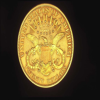

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879. The obverse side displays a left-facing Liberty head, with the date and coin specifications inscribed around its edge. On the reverse side, an eagle is depicted, but it includes the Latin motto "DEO EST GLORIA" instead of the usual "IN GOD WE TRUST." This design was part of an initiative to enhance the competitiveness of American coinage in the global market, similar to the introduction of the four-dollar gold coin, the Stella. This particular coin is one of only nine known gold pieces of this design, and it was last sold for $40,000 in 2008. Currently, it is not on display, but it 

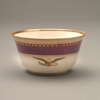

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a significant artifact from 1887, which was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, Lincoln's great-grandson. The cup is made of ceramic and features a striking purple color with white and gold trim, measuring approximately 3 1/4 inches in height. A notable aspect of its history is that it was left behind by President Lincoln on April 14, 1865, the night he was assassinated at Ford's Theatre. A White House servant preserved the cup after noticing it on a windowsill, recognizing its potential historical value. In 1867, Captain D.W. Taylor presented the cup to Robert Todd Lincoln, who kept it as a family heirloom. The cu

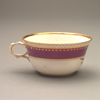

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, an artifact that holds significant historical importance. On April 14, 1865, just before heading to Ford's Theatre for the last time, President Lincoln left this cup on a windowsill, where it was noticed and preserved by a White House servant. The cup, made of ceramic and featuring a striking purple color with white and gold trim, measures approximately 3 1/4 inches in height. It was later gifted to Robert Todd Lincoln, the eldest son of Abraham Lincoln, by Capt. D.W. Taylor in 1887. This cup is part of the National Museum of American History's collection, thanks to Lincoln Isham, Lincoln's great-grandson, who donated it in 1958. It serves 

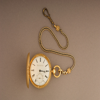

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a symbol of his success as a lawyer. The watch's movement, crafted in Liverpool, was renowned for its precision, capable of keeping time within seconds daily. The case, made in the United States by an unknown manufacturer, was adorned with an 18K gold finish, showcasing high-quality workmanship. A notable feature of this watch is its 18K gold case, which was added by a watchmaker named L. E. Gross after Lincoln's death in 1865. This addition not only preserved the watch's historical significance

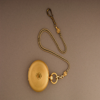

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, was renowned for its precision, capable of keeping time within seconds daily. The case, made in the United States by an unknown manufacturer, was adorned with an 18K gold finish, showcasing high-quality workmanship. A unique aspect of this watch is its hidden message engraved by watchmaker Jonathan Dillon on February 12, 1861, during a time of national crisis. Dillon's engraving, along w

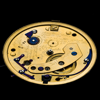

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, is renowned for its high-quality standards, and the case, made in the United States by an unknown artisan, is of the highest caliber. A notable aspect of this watch is its hidden engraving, which was revealed in 2009 after a descendant of Lincoln's watchmaker contacted the museum. The engraving, done while the watch was being repaired, reads “Jeff Davis w

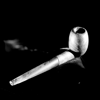

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe, dating back to approximately 1948, which serves as a poignant reminder of the legendary physicist's legacy. Renowned for his groundbreaking theory of relativity and his Nobel Prize, Einstein is also recognized for his distinctive appearance, often characterized by his pipe. Although he reduced his smoking later in life for health reasons, he never lost his affection for the tactile experience of a pipe. This particular pipe shows signs of wear, including a hole in its bit, which reflects its long-term use. Einstein gifted this pipe to his friend Gina Plunguian in 1948, and it was later acquired by the Smithsonian in 1979. It is part of a larger collection of over 1,

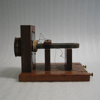

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the invention of the telephone by Alexander Graham Bell, who received the first patent for his innovative device on March 7, 1876. Just three days later, Bell successfully transmitted a message to his assistant, Thomas Watson, marking a significant milestone in communication history. The exhibit includes one of the two telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular telephone is notable for its design, which includes an iron diaphragm and two electromagnets, and it is believed to be one of only six telephones from this era still in existence. Acquired by the Smithsonian in 1923, this artifact is part of a larger collection of nearly 1,0

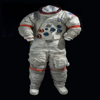

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic artifact from the last Apollo mission that successfully landed astronauts on the moon in December 1972. The mission, which launched on December 7 aboard a Saturn V rocket, included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who was the only geologist to walk on the lunar surface. While Evans remained in orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting a record 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. The mission concluded with a Pacific Ocean landing on December 19, 1

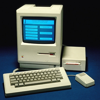

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which was introduced by Apple Inc. in January 1984. This revolutionary device was the first to incorporate a graphic user interface, allowing users to interact with their computers through icons rather than command lines. This concept was inspired by work at Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously promoted the Macintosh with a Super Bowl XVIII advertisement, priced around $2,500. The original Macintosh had only 128K of RAM, which quickly proved inadequate, leading to the release of the Macintosh 512 KB, or "Fat Mac," in September 1984. This model featured a Motorola 68000 microprocessor 

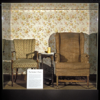

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant piece of American political history: the upholstered wing chair that belonged to Archie Bunker, played by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, which dates back to the 1940s, is upholstered in a vibrant orange-yellow woven fabric and is supported by a sturdy wooden frame with arms and legs. It was acquired from a thrift store in Southern California and became a central piece in the show, where it was used until a reproduction was created for the final season after it was donated to the Smithsonian. "All in the Family," which aired from 1971 to 1979, was a revolutionary sitcom that tackled complex social issues, making it a p

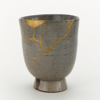

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning tea bowl from the 17th century, originating from the White Satsuma ware tradition in Kagoshima prefecture, Japan, during the Edo period. Crafted from stoneware and adorned with a clear, crackled glaze, this bowl showcases the artistry of kintsugi, a Japanese repair technique that embraces the object's history rather than concealing it. Kintsugi employs lacquer, a natural resin derived from tree sap, which, once cured, becomes a strong and water-resistant adhesive. This repair method not only restores the bowl's functionality but also enhances its aesthetic appeal, as the golden lacquer repairs are prominently featured. The lacquer repairs are particularly striking against the bo

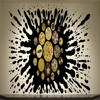

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating work of Yinka Shonibare, an influential artist born in London in 1962. It showcases a striking arrangement of 25 circular canvases, each varying in size, that are set against a large-scale ink splatter pattern applied with a template. The canvases are adorned with intricate foliate designs in black and gold, crafted using Dutch wax printed fabrics. Shonibare's artistic evolution is evident as he moves from grid-like arrangements to these dynamic, overlapping forms. The splatter effect is a playful homage to Jackson Pollock, while the use of gold references Africa's rich oil resources. This work is part of the Smithsonian's collection but is not currently on display.
==> Gro

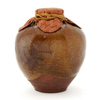

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning tea-leaf storage jar from the 17th century, originating from the White Satsuma ware tradition in Kagoshima prefecture, Japan. The jar is characterized by its distinctive orange-yellow design, which includes a decorative net bag, and is crafted from stoneware with a clear, glossy glaze. Its historical context is intriguing; while it was once used for tea storage, it now serves as a decorative piece, showcasing the intersection of art and functionality. The jar's journey includes a fascinating story—it was initially donated to the Smithsonian's Freer Gallery of Art in 1957 by Mr. and Mrs. John Leverett, and in 1972, it was transferred to the Arthur M. Sackler Gallery, where it is 

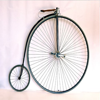

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the original 1886 Columbia Light Roadster high-wheel bicycle, an emblem of springtime and cycling culture in the late 19th century. Manufactured by the Pope Manufacturing Co., the first bicycle manufacturer in the United States, this bicycle was originally priced at approximately $135 and was sold to Charles E. Pratt, the first president of the League of American Wheelmen, in 1887. The bicycle is equipped with a 53-inch front wheel composed of 60 spokes and an 18-inch rear wheel with 20 spokes, showcasing the variety of sizes available to cyclists at the time. Accompanying the bicycle is a historic photograph from 1879, which captures one of the earliest organized cycling tours in America,

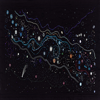

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating work of Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey began later in life, inspired by the beauty of the stars she witnessed while recovering from a serious illness. Her artwork, which incorporates swirling galaxies, reflects her passion for astronomy and celebrates the cultural heritage of her Gwich'in roots. The piece, made from a variety of materials including glass beads, metal, and thread, measures 39 7/8 by 53 1/8 inches and is part of the collection at the National Museum of the American Indian. It was generously gifted by Nazon herself and is currently on display at the museum's site in New

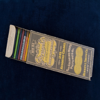

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a pack of Crayola Crayons from 1903, celebrating the iconic art supplies created by the Binney & Smith Company in Easton, Pennsylvania. The name "Crayola," invented by Alice Binney, blends the French word for chalk, "craie," with "oleaginous," reflecting the waxy texture of the crayons. The set includes 28 colors, such as celestial blue and rose pink, and is designed for "young artists." The box, which originally held 28 crayons, now contains 22, showcasing the enduring appeal of these crayons. The packaging illustrates a girl coloring, highlighting the educational and creative aspects of these crayons. Crayola crayons have become synonymous with childhood creativity, inspiring artistic ex

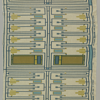

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning textile designed by the renowned Frank Lloyd Wright, an American designer active from 1867 to 1959. Manufactured by F. Schumacher & Co., a prominent New York textile producer established in 1889, the piece showcases a geometric design composed of rectangular blocks in soothing light blue and varying olive shades, all set against an off-white background. The textile's dimensions are 120 cm in height and 57.5 cm in width, with a repeat height of 63.5 cm. Additionally, five alternative colorways are displayed on the upper back of the piece. This textile is part of the Cooper Hewitt, Smithsonian Design Museum collection, gifted by Mr. and Mrs. Burton Tremaine in 1956.
==> Ground tru

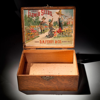

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the historical significance of seed packets during the spring season. Seed companies like D.M. Ferry & Co. used these wooden boxes to display their seeds, often adorned with vibrant labels, in retail stores. These boxes not only served as practical storage solutions but also functioned as marketing tools, as they were often placed on countertops to attract the attention of customers. The seed box on display is particularly notable for its association with the "commission box," a design that revolutionized retail display methods. Acquired by the Smithsonian in 1986, this piece is part of a larger collection that includes over 10,000 seed trade 

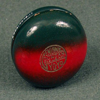

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable wooden yo-yo from the 1930s, crafted by the renowned Donald F. Duncan Sr., known as the "Yo-Yo King." The yo-yo, characterized by a green design with a striking red stripe, is adorned with the seal "Genuine Duncan Yo-Yo, Reg. US Pat," highlighting its historical significance. The yo-yo's design is further enhanced with a silk screen featuring a native American, symbolizing the brand's association with entertainment and culture. Donald F. Duncan Sr. is credited with popularizing the yo-yo in America, having initially discovered it during a business trip to San Francisco in 1928. He quickly recognized its commercial potential and began producing wooden yo-yos, understanding the 

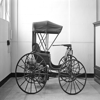

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Duryea Automobile, a pivotal artifact in the history of American transportation. In 1893, Frank Duryea conducted a road test of this vehicle, which is believed to be the first American-made automobile. The automobile is powered by a one-cylinder, four-cycle, four-horsepower gasoline engine, and it includes several innovative features such as a gear transmission and a spray carburetor. Frank and his brother Charles, along with financial backers, established the Duryea Motor Wagon Company in 1896, marking a significant milestone in the automotive industry. This vehicle was donated to the Smithsonian's National Museum of American History in 1920 and underwent restoration in 1958, ensuring

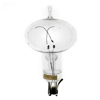

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an iconic invention from 1879 that symbolizes Thomas Edison's legacy as a quintessential American inventor. This carbon-filament bulb was pivotal in demonstrating the first practical electric incandescent lamp, which operates by allowing an electrical current to pass through a metal filament, heating it to a point where it glows brightly. To protect the filament from air exposure and extend its life, it is encased in a glass bulb filled with inert gas. This landmark achievement occurred during Edison's first public demonstration of his invention at his Menlo Park laboratory on New Year's Eve in 1879. Edison's contributions to technology are vast, with a record of 1,0

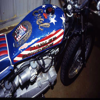

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the thrilling career of Evel Knievel, a legendary daredevil known for his daring stunts. Born Robert Craig Knievel, he gained fame in the 1960s, captivating audiences with his breathtaking motorcycle jumps. The XR-750, weighing approximately 300 pounds and made from steel, aluminum, and fiberglass, was a key part of his performances, including the iconic jump over 14 Greyhound buses in 1975. Knievel's shows not only showcased his extraordinary skills but also highlighted the excitement of live entertainment, drawing in millions of viewers. Although he suffered numerous injuries throughout his career, including 35 to 4

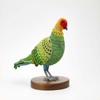

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Laurel Roth Hope's “Biodiversity Reclamation Suit: Carolina Parakeet,” a striking work created in 2009 that employs humor to address the serious issue of species extinction. The piece features a crocheted suit that allows a common rock pigeon to impersonate a Carolina parakeet, a North American bird that became extinct in the 1920s. Through this artistic intervention, Hope playfully suggests that biodiversity can be restored, albeit temporarily. Her work not only highlights the beauty of the Carolina parakeet but also encourages reflection on the broader issue of species extinction and the importance of conservation efforts. The piece is part of the Smithsonian American Art Museum's collec

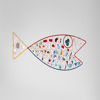

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the captivating work of Alexander Calder, an American artist known for his innovative sculptures. Calder's journey began as a mechanical engineer before he transitioned into art, where he initially supported himself as a freelance illustrator while studying at the Art Students League in New York. His artistic evolution was catalyzed by a move to Paris, where he was influenced by avant-garde artists and began creating wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, Calder invented the “mobile,” a kinetic sculpture that moves with air currents. He also created “stabiles,” which are static sculptures, and standing m

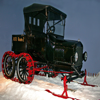

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the innovative solutions adopted by rural mail carriers in the early 20th century to overcome the challenges posed by snowy conditions. As automobiles became more common for mail delivery, many carriers found themselves struggling in deep snow. To address this, Virgil White pioneered the conversion of cars into snowmobiles by replacing front tires with skis and fitting caterpillar treads on the rear. His first prototype was a Buick Model G, but he soon began producing kits for the popular Ford Model T, which sold for $250 to $400. This particular Model T was owned by Harold Crabtree, a rural mail carrier from Central Square,

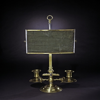

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact from American history: Thomas Jefferson's portable writing desk, which he used to draft the Declaration of Independence in 1776. The desk, designed by Jefferson himself, is characterized by its hinged writing board and adjustable candlesticks, all housed in a sturdy mahogany frame. As the Second Continental Congress convened in the summer of 1776, Jefferson was tasked with articulating the colonies' desire for independence from Britain. His draft, adopted on July 4, not only reflected the ideals of liberty but also served as a foundational document for the new nation. The desk accompanied Jefferson throughout his life, witnessing his journey from a revolutionary lead

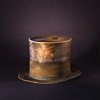

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, an iconic artifact housed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was known for his distinctive high top hats, and this particular hat was crafted by Washington hat maker J.Y. Davis. While the exact date of its acquisition is uncertain, it is believed that Lincoln purchased the hat in the 1850s. The hat's significance is heightened by the events of April 14, 1865, when Lincoln wore it to Ford's Theatre. Following his assassination, the War Department preserved the hat along with other belongings, and with Mary Lincoln's permission, it was transferred to the Patent Office and later to the Smithsonian in 1867. I

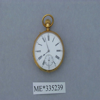

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Helen Keller, an extraordinary figure who lived from 1880 to 1975. Keller, who became deaf and blind due to illness at nineteen months old, overcame significant challenges with the help of her teacher, Anne Sullivan. Under Sullivan's guidance, Keller learned to communicate and eventually graduated from Radcliffe College in 1904, making history as the first deaf-blind person to earn a Bachelor of Arts degree. The watch, a gift from John Hitz in 1892, is a Swiss-made device that features a 18K gold case and a movement crafted in Liverpool. Notably, it was modified to include pins that allow Keller to tell time by touch, a testament to her resilience

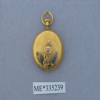

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Helen Keller's touch watch, dating back to the late 1800s. Keller, who lost her sight and hearing as a child, became a prominent advocate for women's rights and disability advocacy. She is particularly recognized for her role in founding the American Civil Liberties Union and her association with Radcliffe College, where she was the first deaf-blind person to earn a Bachelor of Arts degree. The watch, a gift from John Hitz in 1892, is a Swiss-made device that allows time to be discerned through tactile means, featuring pins around its edge to indicate the hours. This watch symbolizes Keller's resilience and determination, embodying her spirit as 

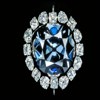

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., crafted in New York, which showcases a primary gem weighing 45.52 carats. The diamond is a modified antique cushion cut, characterized by its unique square-rounded shape, and is set in a captivating design of 16 modified antique cushion cuts, totaling 123 carats. The necklace is crafted from 18K white gold, enhancing the beauty of the diamond. This exquisite piece is part of the Mineral Sciences collection at the Smithsonian's National Museum of American History, specifically within the Gems category. It was gifted by Mrs. Anne L. Bernat, and its USNM number is NMNH G3551-00.
==> Ground truth answer: This exhibit features a stunning diamond nec

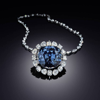

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., crafted in New York, which showcases a primary gem weighing an impressive 45.52 carats. The gemstone is a dark gray-blue modified antique cushion cut, showcasing its unique character. The necklace is set with a central diamond, complemented by 21 additional diamonds, totaling 129.20 carats. This exquisite piece is crafted from a mixture of materials, including platinum, gold, and diamonds, and is classified under the Mineral Sciences department, specifically within the Gems collection. The USNM Number for this necklace is NMNH G3551-00, and it was last examined on September 25, 2022. This exhibit is part of the Smithsonian's

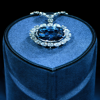

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the stunning diamond necklace that belonged to the late Princess Diana, crafted by the esteemed Cartier, Inc. The diamond, weighing an impressive 45.52 carats, is a captivating dark gray-blue hue, set in a modified antique cushion cut. The necklace is elegantly designed with a primary gemstone set in a heart shape, complemented by 22 smaller diamonds, creating a striking visual impact. This exquisite piece was gifted to the Smithsonian by the Royal Family through the Channel Islands' Privy Purse, showcasing its historical significance. The necklace is part of the Mineral Sciences collection, specifically within the Gems category, and is

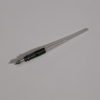

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. This pen, along with over 70 identical ones, was gifted to prominent figures in the Civil Rights Movement as a gesture of appreciation for their efforts. The journey to this landmark legislation was complex, initially proposed by President John F. Kennedy, who could not see it through due to his assassination in November 1963. President Johnson then took the lead, navigating the bill through Congress, where it faced the longest filibuster in history, lasting 57 days. The Civil Rights Act represented a crucial first step

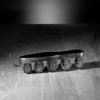

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, crafted by Robert John Tyers. As the 19th century approached, skaters sought to enhance their performance by incorporating wheels into their footwear. The Volito is notable for its unique design, which includes a wooden sole and five wooden wheels arranged in a single row, along with a curved iron bar that functions as a basic brake. What sets this skate apart from its contemporaries is its unequal wheel sizes—larger in the center and smaller at the ends—designed to facilitate easier turns for skaters. This historical artifact is part of the National Museum of American History's collection, although it is currently not on display.
==> Ground truth ans

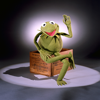

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a beloved character created by Jim Henson, who has been a staple of children's entertainment since his debut in 1955 on "Sam and Friends." Kermit is known for his calm and rational nature, often navigating the chaotic world around him with grace. He is particularly famous for his song “Bein' Green,” which addresses the challenges he faces due to his color and ultimately celebrates his identity. The puppet is made from a combination of materials, including synthetic fiber and felt, and stands at 27 inches tall. This exhibit is part of the "Entertainment Nation" display at the National Museum of American History, and Kermit is also featured in the "Entertainment Nation" onli

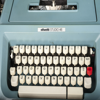

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), an influential science fiction writer whose work has left a lasting impact on literature and culture. Butler is best known for her groundbreaking series, including the Patternist series and the Xenogenesis trilogy, as well as her thought-provoking novels such as Wild Seed and Kindred. Her writing is characterized by a blend of African American history and speculative fiction, exploring themes of alien life and the human experience. By centering characters from the African diaspora, particularly in Wild Seed and Kindred, she empowered readers of African descent to envision themselves as heroes in her fictional worlds.

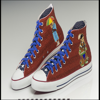

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a striking pair of sneakers created by Kiowa artist Teri Greeves in 2004. Crafted from cotton canvas and commercial rubber, these sneakers stand at 33 x 11 x 15 cm and are adorned with intricate overlay beadwork, showcasing the intersection of contemporary art and traditional Native American techniques. The National Museum of the American Indian acquired this piece from Thirteen Moons Gallery in Santa Fe, New Mexico, highlighting the ongoing evolution of Native American artistry.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique ble

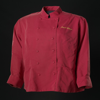

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and Chef Leah Chase. Chef Chase, who passed away in 2019, is celebrated as “The Queen of Creole Cuisine” and was a pivotal figure in the civil rights movement. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining venue adorned with white tablecloths and African American art. It was during these meals that influential leaders discussed key civil rights strategies, earning the restaurant the nickname “The Civil Rights Leadership Council.” Chase's culinary artistry combined Creo

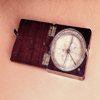

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that belonged to William Clark, an explorer of the early 1800s. Acquired in 1803 from Thomas Whitney in Philadelphia, the compass was part of a collection of instruments that Clark and his partner, Meriwether Lewis, procured for their expedition under the leadership of President Thomas Jefferson. The compass is crafted from brass and features a mahogany case, with a silver-plated rim graduated in degrees. A paper dial, secured by a brass bezel, enhances its functionality. The instrument's history is intriguing; while it remained with Clark throughout his life, it was later sold to Captain Robert A. McCabe, whose heirs donated it to the Smithsonian in 1933. This 

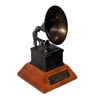

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Bob Newhart's 1960 Grammy Award, celebrating the illustrious career of the comedian and actor born on September 5, 1929. Newhart, known for his deadpan delivery and insightful commentary on societal issues, gained fame with his groundbreaking comedy album, The Button-Down Mind of Bob Newhart, which was the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year. He also holds the unique distinction of being the only comedian to receive a Grammy for Best New Artist. Newhart's television legacy includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, both of which have left a lasting impact on the sitcom landscape. His accolad

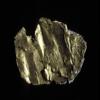

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is recognized as the first piece of gold unearthed at Sutter's Mill in California, an event that sparked the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a glimmering object in the mill's tailrace. Upon closer inspection, he identified it as a thin scale of pure gold. Marshall later presented this find to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold discovered in Northern California. By August 1848, this nugget and other samples were sent to Washington, D.C., where Presiden

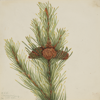

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a watercolor painting by Mary Vaux Walcott, created in 1921, that depicts a lodgepole pine (Pinus Contorta murrayana), a native species of the Canadian Rockies. Walcott's artistic journey began when a botanist encouraged her to paint a rare arnica flower, leading to her marriage to Charles Doolittle Walcott, the Secretary of the Smithsonian, in 1914. Together, they spent extensive time in the Canadian Rockies, where Mary produced hundreds of watercolor studies of local flora. Her work culminated in the publication of 400 illustrations in the five-volume series "North American Wild Flowers" from 1925 to 1929, followed by her illustrations in "North American Pitcher Plants" in 1935. Her cont

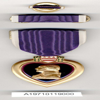

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the United States Purple Heart, a prestigious military decoration that recognizes the sacrifice of those who have served in the U.S. Armed Forces. The medal is crafted in a heart shape, showcasing a gold relief of George Washington's profile against a rich purple enamel background. Above the bust, a shield depicts Washington's family coat of arms. The reverse side is inscribed with "FOR MILITARY MERIT," highlighting its significance. The medal is suspended from a silk ribbon that is purple with a white edge stripe. It is made from a combination of materials, including copper alloy, gold plating, and enamel, and measures approximately 3.7 by 1.1 by 8.1 centimeters. This particular piece is 

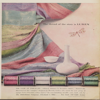

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an advertisement from the 1950s that highlights the innovative work of Dorothy Liebes (1897–1972), an influential American textile designer. Liebes is celebrated for her unique approach to design, which blended vibrant colors and rich textures to create a distinctly American aesthetic. Her work, often referred to as the “Liebes Look,” is characterized by bold colors and rich textures, and she collaborated with notable architects and designers of her time, including Frank Lloyd Wright and fashion luminaries like Adrian. The advertisement showcases her use of Lurex, a metallic yarn that became a hallmark of her style. This particular advertisement is part of the Smithsonian's Archives of Ame

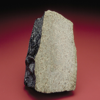

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment, a significant specimen housed at the Smithsonian's National Museum of Natural History. The Nakhla meteorite is one of only thirty-four meteorites known to have originated from Mars, and it is particularly notable for its entry into Earth's atmosphere on June 28, 1911, at approximately 9 a.m. in the Nakhla region of Alexandria, Egypt. The meteorite's explosive descent was witnessed by many, with fragments being found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the meteorite's fall, and in 1962, it added a notable 480-gram fragment, bringing the total collection to 650 grams by the 1970s. The Nakhlites, as these M

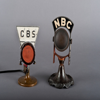

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a significant artifact from the "Fireside Chats" delivered by President Franklin D. Roosevelt, beginning on March 12, 1933. As the nation grappled with the Great Depression, Roosevelt's ability to communicate directly with the American people through radio was pivotal. This particular microphone, adorned with the logos of the National Broadcasting Company, was preserved by Carleton Smith, who was instrumental in setting up the broadcasts. The first chat took place in the Lincoln Study, while subsequent ones were held in the Diplomatic Reception Room of the White House. Roosevelt's innovative use of radio not only comforted and informed the public but also helpe

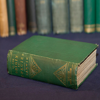

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "On the Origin of Species," written by Charles Darwin in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a ship that played a pivotal role in Darwin's scientific endeavors. The Beagle was launched from the Thames and underwent modifications before embarking on its second survey voyage on December 27, 1831, with Darwin on board as a naturalist. Over the course of five years, he meticulously documented fossils, plant specimens, and geological formations in South America and the Galápagos Islands, leading to his groundbreaking theory of evolution by natural selection. The publication of his find

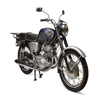

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book sold over a million copies in its first year and initiated a cultural movement focused on reevaluating the relationship between humans and technology. Pirsig's inspiration arose from a transformative month-long motorcycle trip he took with his son Chris in 1968, during which they traveled 5,700 miles from Minnesota to San Francisco. This journey not only deepened their father-son bond but also provided Pirsig with profound insights into personal growth and the nature of existence. The book has since s

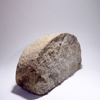

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece, an important artifact from 1620, located at the National Museum of American History. This rock is traditionally recognized as the landing site of the Mayflower Pilgrims, led by William Bradford, who settled in Plymouth, Massachusetts. Bradford, a prominent leader and governor of the Plymouth Colony, is also credited with establishing Thanksgiving as a national holiday in the United States. The rock's history is somewhat mysterious; it was moved in 1774 by Plymouth townspeople, who intended to relocate it to the town square, resulting in its accidental splitting. The bottom half remained in place, while the top half was transported to a meeting house. It wasn't unti

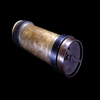

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, showcasing the innovative pneumatic tube systems that revolutionized mail delivery in the late 1800s. These systems, which began operating in Philadelphia in 1893 and were soon followed by New York City in 1897, utilized underground tubes to transport mail efficiently. Each container, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching speeds of approximately 35 miles per hour. At its peak, the system processed an impressive six million pieces of mail daily, with five carriers dispatched every minute. The pneumatic tube network eventually expanded to cities like Boston, Chicago, and St. Louis, lead

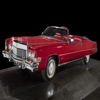

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic 1973 red convertible Eldorado from the National Museum of American History, a significant piece of automotive history associated with the legendary rock band The Eagles. The Eldorado was part of a collection owned by band member Don Henley and was famously driven to a concert at the Hollywood Bowl on September 7, 1976. The vehicle is notable for its luxurious design, featuring a white leather interior and a powerful 8.0-liter V8 engine. It was last driven in 2006 and is part of the museum's extensive collection of 137 million artifacts, which also includes the original recording of “Take It to the Limit,” a song that encapsulates the spirit of the era. The Eagles, formed in 1966

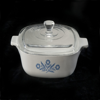

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's distinctive blue cornflower design. This dish is a staple of holiday cooking, often used for preparing and serving side dishes during the festive season. The CorningWare brand is known for its innovative glass-ceramic material, which was initially developed for military applications during World War II. After the war, it was repurposed for home cookware, offering a unique combination of strength, non-porousness, and the ability to withstand rapid temperature changes. This versatility allowed the dish to be used for cooking, freezing, and serving, streamlining kitchen tasks. In

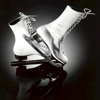

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary figure skater from Norway, dating back to around 1945. Henie is celebrated for her significant contributions to women's figure skating in the late 1920s and 1930s, where she introduced the fashionable white leather skates that have become standard today. Her innovative approach to skating, which combined dance with athleticism, won her numerous accolades, including 10 consecutive world titles starting in 1927. Henie's performances were particularly notable for her choreography and the way she interacted with her skates, captivating audiences worldwide. Beyond her athletic achievements, she also made history as the first to popularize t

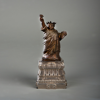

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: a miniature replica of the Statue of Liberty, often referred to as the American Committee Model. Produced in the United States, this statuette was created in large quantities to finance the construction of the statue's pedestal in New York Harbor. The design, crafted by French sculptor Frédéric-Auguste Bartholdi, was available in both six-inch and twelve-inch sizes, with the six-inch model priced at one dollar and the twelve-inch model at five dollars. A national campaign promoted these models, with the goal of selling one million to help finance the pedestal. Richard Butler, a rubber manufacturer from New York, led the American Committee that oversaw the production 

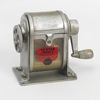

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, manufactured by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). As students prepare for school, this sharpener evokes nostalgic memories of classroom life. The Dexter Model 3, an improvement on its predecessor, introduced in 1914, featured a rotating wheel with openings for various pencil sizes, enhancing its usability. By the 1920s, APSCO had produced a diverse range of sharpeners, each with unique designs and price points. While the company enjoyed success in the mecha

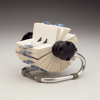

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a quintessential office supply that has become synonymous with organization. Manufactured by the Rolodex Corporation in the USA, this item is constructed from a mix of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex is designed to hold A-Z index cards for efficient contact management, with its rotating mechanism allowing for easy access to business contacts. Despite the rise of digital alternatives, the Rolodex remains a beloved tool, symbolizing resilience in the face of technological change. The invention is credited to Arnold N

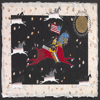

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the artwork of Jim Yellowhawk, a Cheyenne River Lakota artist, who created the piece titled “Lakota Horse Mask.” The artwork, crafted in 2008, is a mixed-media creation that includes acrylic on paper and gold leaf, with the edges adorned in black and white. It measures 10 x 7 inches and is framed in a 12 x 10 inch wood frame. The piece is part of the Smithsonian's National Museum of the American Indian collection, specifically within the online exhibition “Horse Nation.” The museum also offers a video that explores the cultural significance of horses in Native American societies, which can be accessed through the museum's Native Knowledge 360º program. This program aims to provide educator

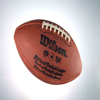

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a key artifact from Super Bowl XIV, which took place on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, known for its premium leather and durable construction, making it the official ball of the NFL since Super Bowl II in 1968. The football on display was used during the game where the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Quarterback Terry Bradshaw also earned the Most Valuable Player award for the second consecutive year. This significant piece is part of the Smithsonian's vast collec

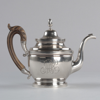

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning silver teapot crafted by Peter Bentzon, an American artisan active from around 1783 to after 1850. The teapot showcases a gracefully curved vase shape that rests on a spreading pedestal foot, with a gracefully scrolling wooden spout topped with an incised patera and a wooden scroll handle capped with wood leaf. The hinged domed cover is finished with an acorn finial, adding a charming touch to the design. Notably, the teapot bears the engraved monogram "MC" and the name "Rebecca Dawson" along the bottom rim, indicating its historical significance. This exquisite piece is part of the Smithsonian National Museum of African American History and Culture's collection, gifted by Ms. D

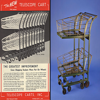

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Telescoping Shopping Cart, an innovative design from 1949 by Orla E. Watson, who was awarded Patent No. 2,797,530. This cart, which made its debut in 1947 at Floyd's Super Market in Kansas City, Missouri, was designed to nest for compact storage, allowing for efficient use of space. Each cart, capable of holding 20 standard shopping baskets, required only one-fifth of the area of a conventional cart when parked. This exhibit is part of the National Museum of American History's first major exhibition dedicated to food history, which highlights the significant changes in food shopping and consumption patterns in postwar America. For additional insights into the evolution of food shopping

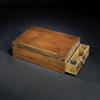

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, an essential tool he used while drafting the Declaration of Independence in 1776. The desk, which includes a hinged writing board and a drawer for writing materials, was designed by Jefferson himself, reflecting his commitment to practicality and organization. As a delegate from Virginia, he was tasked with articulating the colonies' desire for independence from Britain, a task that would shape the course of American history. The Continental Congress officially adopted the declaration on July 4, 1776, and this document, along with the desk, accompanied Jefferson throughout his life, serving as a symbol of his legacy as a statesman and president. In

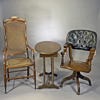

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from American history: the chair used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee on April 9, 1865, at Appomattox Court House, Virginia. This meeting was pivotal in the conclusion of the Civil War, with Grant's chair serving as a symbol of the momentous event. The chair, made of wood and measuring 37.5 inches high, 21.5 inches wide, and 17.5 inches deep, is a testament to the historical context. It was initially gifted to Major General Custer's wife by General E. W. Whitaker, and it was later acquired by the Smithsonian Institution in 1896. This piece is part of the "Price of Freedom" exhibition at the National Museum of Am

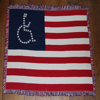

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that has been transformed into a powerful symbol of disability rights, crafted by members of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, incorporates the universal access symbol, created by disability-rights advocates, into the design of the American flag. This act of civil disobedience serves to highlight the fight for disability rights, which gained momentum after World War II as individuals with disabilities formed communities to advocate for their rights. The blanket's construction, with its fringed edges, reflects the artistry and activism of the movement. ADAPT, founded in 1983, co

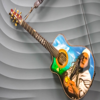

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer and Grammy Award-winning artist, who is celebrated for his vallenato music. Vallenato, an energetic genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic storytelling and traditional rhythms from the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, but it gained international recognition in the 1990s when Vives and other artists began to incorporate pop and rock influences, allowing it to resonate with broader audiences. The guitar on display was crafted by a Colombian luthier and features an airbrushed image of an Arhuaco. It was las

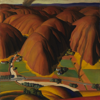

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "The Burning Mountain," an oil painting by Ross Dickinson, created in 1934 and measuring 39 7/8 by 50 1/8 inches. It is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Dickinson's artistic journey began when he was inspired by the grandeur of the California landscape while working as a forest ranger. He later studied at the Art Students League in New York and was influenced by the modernist movement, particularly the works of his peers in the Public Works of Art Project. His paintings often depict the intersection of nature and human activity, capturing the beauty of California's landscape while addressing the threats posed by wildfires and the econo

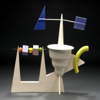

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Peter Shire, an artist born in Los Angeles in 1947. It showcases his Weathervane Teapot, a striking piece created in 1981, which exemplifies his unique approach to ceramic art. Shire's teapots are characterized by their playful designs, incorporating various shapes and colors, including squares, spheres, and whimsical rods. The teapot's structure invites interaction, with its stacked squares and hanging elements, yet it also raises questions about its functionality. Shire aimed to challenge conventional notions of "tea-time," making it a more inclusive and accessible experience. After 1985, he shifted his focus to furniture design, marking a significant shift in his 

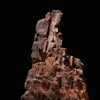

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a poignant artifact from the Civil War era, currently displayed at the Smithsonian's National Museum of American History. The stump originates from a once-magnificent oak tree that stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864. On that fateful day, the area became the site of intense combat between Confederate forces and Union troops, resulting in a bloody battle that would be remembered as the Bloody Angle. The oak tree was caught in the crossfire, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence and heroism witnessed during the battle. The Battle of Spotsylvania Court House

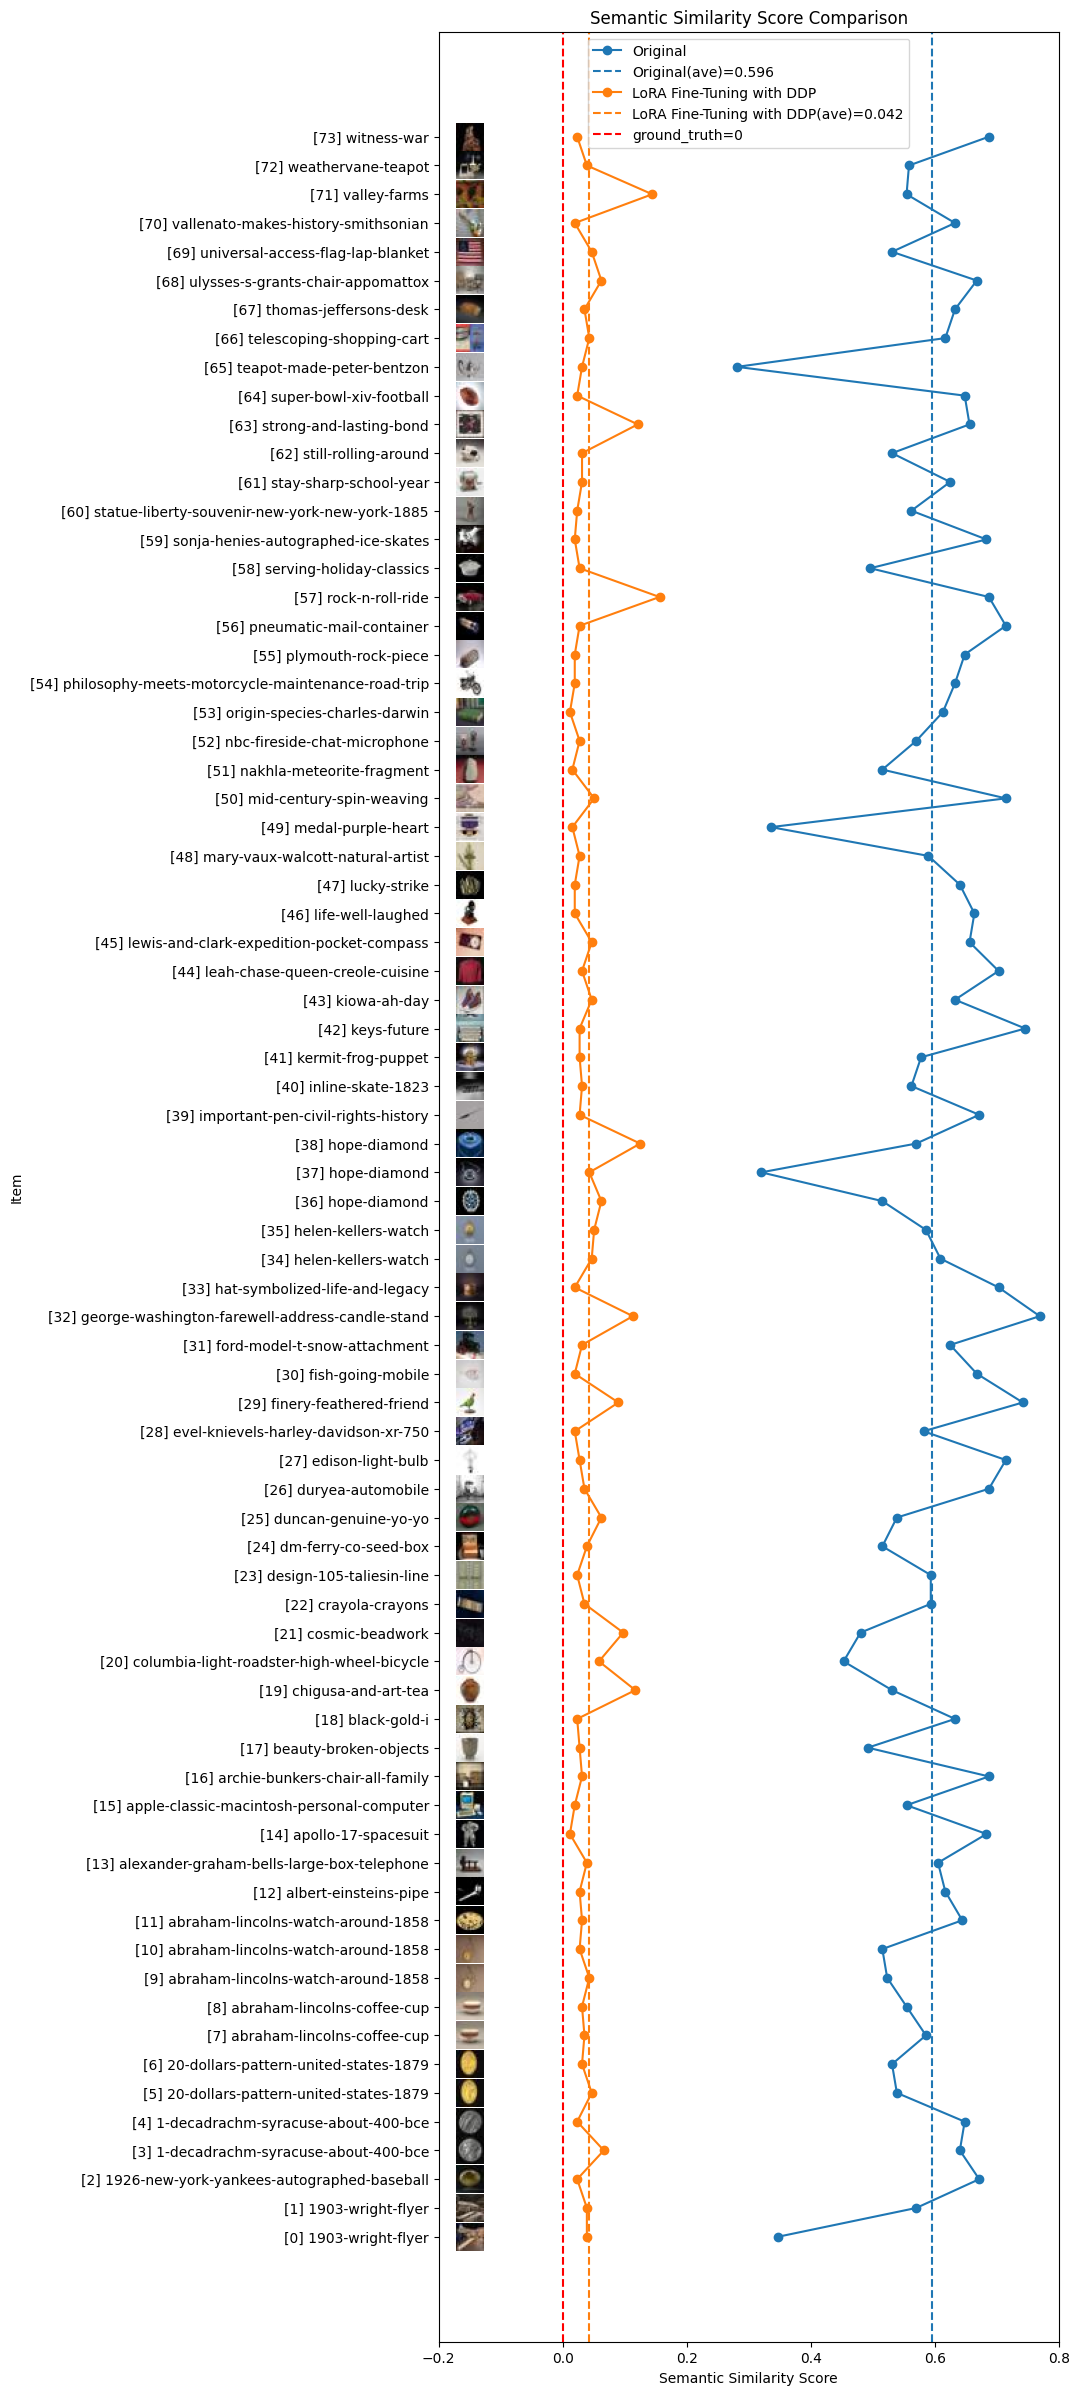

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 14)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('LoRA Fine-Tuning with DDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...
==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.e